In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

# 4. Computing Solution Concepts of Normal-form games

This chapter deals with the algorithms to compute things like equilibria, domination, etc. It starts with the easiest one, which is the zero-sum game:

## 4.1 Computing Nash equilibria of two-player, zero-sum games

In the previous chapter the idea of a minmax and maxmin solution was introduced. In a zero sum 2-player game it was noted that at equilibrium each player receives their minmax / maxmin value. We can use this to calculate the equilibrium by linear programming. 

Minmax means that the agent makes their best decision, given the other player will then minimise their return. Say I am player 1 and my best action is $A_1^j$. Then player 2 minimises my return by finding a mixed strategy $s_2$, to minimise:

$$\sum_{k} u_1(A_1^j,A_2^k)s_2^k$$

Note: Here $k$ is the index of each action player 2 could take.

This can be re-written in linear-programming style as:

$$
\begin{align*}
\text{minimise} \quad & U_1 \\
\text{subject to} \quad & \sum_{k} u_1(A_1^j,A_2^k)s_2^k \leq U_1 \\
\text{} \quad & \sum_{k} s_2^k=1 \\
\text{} \quad & s_2^k\geq 0 \\
\end{align*}
$$

(Why? Well, $\min f(x)$ is the same as $\min y$ subject to $f(x)\leq y$.

Of course, we don't actually know which action $j$ is the best for player 1, so we need to check every one:

$$
\begin{align*}
\text{minimise} \quad & U_1 \\
\text{subject to} \quad & \sum_{k} u_1(A_1^j,A_2^k)s_2^k \leq U_1 \quad \forall A_1^j \\
\text{} \quad & \sum_{k} s_2^k=1 \\
\text{} \quad & s_2^k\geq 0 \\
\end{align*}
$$

Consider the Matching Pennies problem again:

$
\begin{array}{c|cc}
\text{} & \text{H} & \text{T} \\
\hline
\text{H} & 1,-1 & -1,1 \\
\text{T} & -1,1 & 1,-1 \\
\end{array}
$

Written using the above strategy for player 1 this gives (here $s_2^1$ being the chance of player 2 going heads, $s_2^2$ their chance of tails):

$$
\begin{align*}
\text{minimise} \quad & U_1 \\
\text{subject to} \quad & s_2^1 - s_2^2 \leq U_1 \quad \text{(player 1 goes heads)} \\
\text{} \quad & -s_2^1+s_2^2 \leq U_1 \quad \text{(player 1 goes tails)} \\
\text{} \quad & s_2^1 + s_2^2=1 \\
\text{} \quad & s_2 \geq 0 \\
\end{align*}
$$

The answer here is that $s_2^1=s_2^2=\frac{1}{2}$. 

Here is an example for the more complicated game paper/scissors/rock. Note that scipy does $\min c\cdot x$, subject to $A\cdot x \geq b$, so the signs are flipped here in the function call.

In [2]:
c = np.array([0,0,0,1])
A_ub = np.array([
    [0,-1,1,-1], # PAPER. If player 2 now goes paper player 1 gets 0, -1 if scissors, 1 if rock.
    [1,0,-1,-1], # SCISSORS. Note, as above the -1 at the end is because a+b+c<d is turned into a+b+c-d<0
    [-1,1,0,-1], # ROCK.
])
b_ub = np.array([0,0,0])
A_eq = np.array([[1,1,1,0]])
b_eq = np.array([1])
res = linprog(c, A_ub=-A_ub, b_ub=-b_ub, A_eq=A_eq, b_eq=b_eq, )
print("Player 2 strategy at equilibrium:",res["x"].round(2)[:3])
print("Player 1 utility:",res["x"].round(2)[-1])

Player 2 strategy at equilibrium: [0.33 0.33 0.33]
Player 1 utility: 0.0


There we go. Unsuprisingly, the utility is 0 and the best option is to be random. 

We can also work out the strategy for player 1. One option is to do the above again in reverse. Another is to do maxmin instead, which corresponds to the dual problem:

$$
\begin{align*}
\text{maximise} \quad & U_1 \\
\text{subject to} \quad & \sum_{k} u_1(A_1^j,A_2^k)s_1^j \leq U_1 \quad \forall A_2^k \\
\text{} \quad & \sum_{j} s_1^j=1 \\
\text{} \quad & s_1^j\geq 0 \\
\end{align*}
$$

As a final note it can be useful to reformulate the equations from before (or the ones right above) by adding slack variables and turning the inequalities into equalities:

$$
\begin{align*}
\text{minimise} \quad & U_1 \\
\text{subject to} \quad & \sum_{k} u_1(A_1^j,A_2^k)s_2^k + r_1^j = U_1 \quad \forall A_1^j \\
\text{} \quad & \sum_{k} s_2^k=1 \\
\text{} \quad & s_2^k\geq 0 \\
\text{} \quad & r_1^j\geq 0 \\
\end{align*}
$$

### 4.1.1 Note on 2-action games

While the next section will show it is complicated to calculate equilibria in general two-player games, it is thankfully somewhat simple if there is only one action each.

Consider the table:

$
\begin{array}{c|cc}
\text{} & \text{A} & \text{B} \\
\hline
\text{A} & x_{11},y_{11} & x_{12},y_{12} \\
\text{B} & x_{21},y_{21} & x_{22},y_{22} \\
\end{array}
$

Say the probability of $A$ is $s_1$ and $s_2$ respectively. Then the benefit player 1 expects is:

$$x_{11}s_1s_2+x_{12}s_1(1-s_2)+x_{21}(1-s_1)s_2+x_{22}(1-s_1)(1-s_2)$$

Which can be expanded as:

$$x_{11}s_1s_2+x_{12}s_1-x_{12}s_1s_2+x_{21}s_2-x_{21}s_1s_2+x_{22}-x_{22}s_2-x_{22}s_1+x_{22}s_1s_2$$

Collecting the $s_1$ term:

$$s_1(x_{11}s_2+x_{12}-x_{12}s_2-x_{21}s_2-x_{22}+x_{22}s_2)+x_{21}s_2+x_{22}-x_{22}s_2$$

In order for player 1 to be indifferent between their actions we need to set the contents of the bracket to 0:

$$x_{11}s_2+x_{12}-x_{12}s_2-x_{21}s_2-x_{22}+x_{22}s_2=0$$

Solving for $s_2$:

$$s_2=\frac{x_{22}-x_{12}}{x_{11}-x_{12}-x_{21}+x_{22}}$$

We can see this in an example game, e.g., the Battle of the Sexes:

$
\begin{array}{c|cc}
\text{} & \text{A} & \text{B} \\
\hline
\text{A} & 2,1 & 0,0 \\
\text{B} & 0,0 & 1,2 \\
\end{array}
$

Here the value for player 2 is $\frac{1-0}{2-0-0+1}=\frac{1}{3}$, as expected.

For player 1 the formula is exactly the same, but with $y$ instead of $x$.

## 4.2 Computing Nash equilibria in general two-player games

### 4.2.1 Complexity

Unfortunately, computing Nash equilibria is a computationally challenging problem. It can be shown that it belongs to a class called PPAD, which it is believed grows exponentially.

### 4.2.2 An LCP formulation and the Lemke-Howson algorithm

#### The LCP formulation

Although the problem of finding a Nash equilibrium in a general two player game can't be encoded as a linear program, it can be encoded as a linear complementarity problem (LCP). We do this as follows. We note that at equilibrium if agent 2 has strategy $s_2$ then any actions with a non-zero probability in $s_1$ are equally good, and therefore must give $U_1$, the optimal value:

$$
\begin{align*}
\text{} \quad & \sum_{k} u_1(A_1^j,A_2^k)s_2^k = U_1 \quad \forall A_1^j|s_1^j>0 \\
\text{} \quad & \sum_{j} u_2(A_1^j,A_2^k)s_1^j = U_2 \quad \forall A_2^k|s_2^k>0 \\
\text{} \quad & \sum_{k} s_2^k=1 \\
\text{} \quad & \sum_{j} s_1^j=1 \\
\text{} \quad & s_2^k\geq 0 \\
\text{} \quad & s_1^j\geq 0 \\
\end{align*}
$$

In order to convert this to a simpler linear format we introduce slack variables, similarly to above:


$$
\begin{align*}
\text{} \quad & \sum_{k} u_1(A_1^j,A_2^k)s_2^k + r_1^j = U_1 \quad \forall A_1^j \\
\text{} \quad & \sum_{j} u_2(A_1^j,A_2^k)s_1^j + r_2^k = U_2 \quad \forall A_2^k \\
\text{} \quad & \sum_{k} s_2^k=1 \\
\text{} \quad & \sum_{j} s_1^j=1 \\
\text{} \quad & s_2^k\geq 0 \\
\text{} \quad & s_1^j\geq 0 \\
\text{} \quad & r_1^j\geq 0 \\
\text{} \quad & r_2^k\geq 0 \\
\text{} \quad & r_1^j\cdot s_1^j = 0 \\
\text{} \quad & r_2^k\cdot s_2^k = 0 \\
\end{align*}
$$

The last two equations state that if an action is included in the strategy, then the strategy at equilibrium must give the maximum utility. In other words, if an action $A_1^j$ is NOT in the solution, then when you take that action there is some gap $r_1^j$ to close in order to get to $U_1$. In an equilibrium strategy the agent is indifferent between the actions they do, so for any action in the solution it must give the optimal utilty.

We can see this using the prisoners dilemma equilibrium as an example.

$
\begin{array}{c|cc}
\text{} & \text{C} & \text{D} \\
\hline
\text{C} & 8,8 & 0,10 \\
\text{D} & 10,0 & 5,5 \\
\end{array}
$

If we expand the first two equations we get:

$$
\begin{align*}
\text{} \quad & u_1(C,C)s_2^C + u_1(C,D)s_2^D + r_1^C = U_1 \\
\text{} \quad & u_1(D,C)s_2^C + u_1(D,D)s_2^D + r_1^D = U_1 \\
\text{} \quad & u_2(C,C)s_1^C + u_2(D,C)s_1^D + r_2^C = U_2 \\
\text{} \quad & u_2(C,D)s_1^C + u_2(D,D)s_1^D + r_2^D = U_2 \\
\end{align*}
$$

And plugging in the values at equilibrium ($s_1^C=s_2^C=0$):

$$
\begin{align*}
\text{} \quad & 8\times 0 + 0\times 1 + r_1^C = 5 \\
\text{} \quad & 10\times 0 + 5\times 1 + r_1^D = 5 \\
\text{} \quad & 8\times 0 + 0\times 1 + r_2^C = 5 \\
\text{} \quad & 10\times 0 + 5\times 1 + r_2^D = 5 \\
\end{align*}
$$
We can see that $r_1^C$ and $r_2^C$ are 5, as this is the amount you expect to lose by going with $C$, and the others are 0. 

#### The Lemke-Howson algorithm

We know that at equilibrium the actions of agent 1 must either have 0 probability in $s_1$, or have a positive probability and be the best / equal best reponse to $s_2$ (if an action was not the best response to $s_2$, it would be better to set it's probability to 0 and use the other). The same is true of strategy $s_2$. This section of the equations above also make this clear:

$$
\begin{align*}
\text{} \quad & \sum_{k} u_1(A_1^j,A_2^k)s_2^k + r_1^j = U_1 \quad \forall A_1^j \\
\text{} \quad & \sum_{j} u_2(A_1^j,A_2^k)s_1^j + r_2^k = U_2 \quad \forall A_2^k \\
\text{} \quad & r_1^j\cdot s_1^j = 0 \\
\text{} \quad & r_2^k\cdot s_2^k = 0 \\
\end{align*}
$$

In fact, a nice way to rewrite the above might be as:

$$
\begin{align*}
\text{} \quad & \sum_{k} u_1(A_1^j,A_2^k)s_2^k = U_1 \quad \forall A_1^j|s_1^j>0 \\
\text{} \quad & \sum_{j} u_2(A_1^j,A_2^k)s_1^j = U_2 \quad \forall A_2^k|s_2^k>0 \\
\end{align*}
$$

So if we take the actions in equilibrium solution $s_1$ which have 0 probability and all the actions which are the best response to $s_2$, we should have the total list of all actions of the agent 1. The same is true of agent 2. So let's define for a solution a labelling function $L$ which lists all the 0-probability and best response actions. 

At equilibrium we will have: $L(s_1)\cup L(s_2) = A_1\cup A_2$

Consider this two-player problem:

$
\begin{array}{c|cc}
\text{} & \text{A} & \text{B} \\
\hline
\text{A} & 3,1 & 1,0 \\
\text{B} & 0,0 & 2,2 \\
\end{array}
$

Applying the approach from earlier we know that this game has an equilibrium at $s_1=\frac{2}{3}$, and $s_2=\frac{1}{4}$.


We can represent the space of both players as follows:

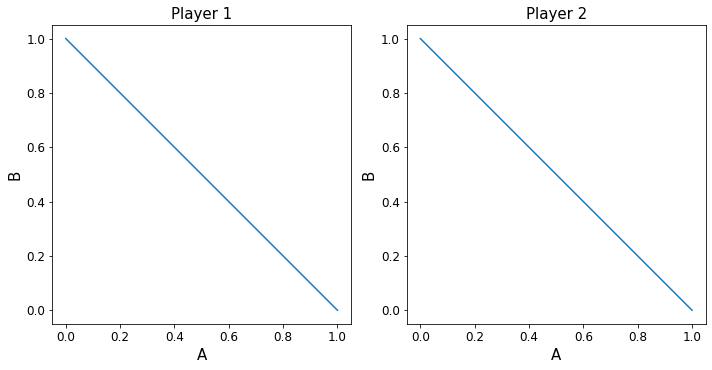

In [23]:
s1_A = np.linspace(0, 1, 100)
s1_B = 1 - s1_A
s2_A = np.linspace(0, 1, 100)
s2_B = 1 - s2_A

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Player 1's plot
ax1.plot(s1_A, s1_B)
ax1.set_aspect('equal', adjustable='box')
ax1.set_title('Player 1',fontsize=15)
ax1.set_xlabel('A',fontsize=15)
ax1.set_ylabel('B',fontsize=15)
ax1.tick_params(labelsize=12)


# Player 2's plot
ax2.plot(s2_A, s2_B)
ax2.set_aspect('equal', adjustable='box')
ax2.set_title('Player 2',fontsize=15)
ax2.set_xlabel('A',fontsize=15)
ax2.set_ylabel('B',fontsize=15)
ax2.tick_params(labelsize=12)

plt.tight_layout()
plt.show()